In [2]:
import os
# Install java
! sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
!which python
!free -g

In [8]:
!pip install --ignore-installed -q pyspark==2.4.5
!gsutil cp gs://hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar /opt/conda/lib/python3.7/site-packages/pyspark/jars/
    
!pip install --ignore-installed spark-nlp==2.5.1
!pip install wordcloud


Copying gs://hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar...
/ [1 files][ 19.4 MiB/ 19.4 MiB]                                                
Operation completed over 1 objects/19.4 MiB.                                     
     |████████████████████████████████| 121 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 364 kB 4.5 MB/s eta 0:00:01


In [5]:
import sparknlp
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, to_timestamp,date_format
from pyspark import StorageLevel
import pyspark.sql.functions as F
from sparknlp.pretrained import PretrainedPipeline
from collections import Counter
from wordcloud import WordCloud
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

def start():
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "54G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2040M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
    return builder.getOrCreate()
spark = start()
spark.version
!ps -ef | grep spark

jupyter  20349 20089 99 17:24 ?        00:00:13 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx54G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=54G --conf spark.kryoserializer.buffer.max=2040M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Spark NLP Licensed --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter  20517 20089  0 17:24 pts/1    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter  20519 20517  0 17:24 pts/1    00:00:00 grep spark


In [ ]:
#df_part1 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-0*.gz")
!gsutil ls "gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-01/coronavirus-tweet-id-2020-01-2*.gz"


In [8]:
def get_words_from_file(file_path):
    words = []
    with open(file_path) as fo:
        for word in fo:
            words.append(word.strip())
    return set(words)

In [14]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
janDF = spark.read.format("json").load("gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-01/coronavirus-tweet-id-2020-01-2*.gz")



In [ ]:
FebDF = spark.read.format("json").load("gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-01/coronavirus-tweet-id-2020-02*.gz")
FebDF.repartition(100).write.save("parquetFile2.parquet")


In [ ]:
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")

janDF.repartition(100).write.save("parquetFile1.parquet")


In [11]:
parquetFile1 = spark.read.parquet("parquetFile1.parquet")
parquetFile1 = parquetFile1.withColumn('tweet_date', from_unixtime(unix_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss ZZZZ yyyy"),"yyyy-MM-dd"))
parquetFile1.createOrReplaceTempView("janView")

In [25]:
spark.sql("""select tweet_date, count(*) from janView group by tweet_date""").show()

+----------+--------+
|tweet_date|count(1)|
+----------+--------+
|2020-01-22|   26046|
|2020-01-23|  152452|
|2020-01-28|  709687|
|2020-01-29| 1608061|
|2020-01-27|  817908|
|2020-01-24|  549042|
|2020-01-26| 1062312|
|2020-01-25|  793858|
|2020-01-21|     184|
+----------+--------+



In [28]:
outbreak_terms = get_words_from_file("outbreakterms.txt")
outbreak_terms_matcher = '(' +"'" + '|'.join(outbreak_terms) + "'" + ')'
query1 = "select geo, place , user from janView where full_text rlike {} and tweet_date in ('2020-01-21','2020-01-22','2020-01-23')".format(outbreak_terms_matcher)
outbreakDF1 = spark.sql(query1)

query2 = "select geo, place , user from janView where full_text rlike {} and tweet_date in ('2020-01-24','2020-01-25','2020-01-26')".format(outbreak_terms_matcher)
outbreakDF2 = spark.sql(query2)

query3 = "select geo, place , user from janView where full_text rlike {} and tweet_date in ('2020-01-27','2020-01-28','2020-01-29')".format(outbreak_terms_matcher)
outbreakDF3 = spark.sql(query3)

In [27]:
outbreakDF2.count()

321501

In [ ]:
pdf1 = outbreakDF1.toPandas()
pdf2 = outbreakDF2.toPandas()
pdf3 = outbreakDF3.toPandas()

In [34]:
len(pdf2)

1117369

In [46]:
def getGeoJson(pdf):
    features = []
    centroid = False
    fuzz = 0.01
    for index, row in pdf.iterrows():
        geodata = {
            "type": "Feature",
            "properties": {
                "name": row["user"]["name"],
                "screen_name": row["user"]["screen_name"]
            }
        }

        if row["geo"]:
            geodata['geometry'] = {
                "type": "Point",
                "coordinates": [
                    row["geo"]["coordinates"][1],
                    row["geo"]["coordinates"][0]
                ]}
        elif row["place"] and any(row["place"]["bounding_box"]):
            bbox = row["place"]["bounding_box"]["coordinates"][0]

            if centroid:
                min_x = bbox[0][0]
                min_y = bbox[0][1]
                max_x = bbox[2][0]
                max_y = bbox[2][1]

                fuzz_x = fuzz * random.uniform(-1,1)
                fuzz_y = fuzz * random.uniform(-1,1)

                center_x = ((max_x + min_x) / 2.0) + fuzz_x
                center_y = ((max_y + min_y) / 2.0) + fuzz_y

                geodata['geometry'] = {
                    "type": "Point",
                    "coordinates": [
                        center_x,
                        center_y
                    ]
                }

            else:
                geodata['geometry'] = {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            bbox[0],
                            bbox[1],
                            bbox[2],
                            bbox[3],
                            bbox[0]
                        ]
                    ],
                }

        if 'geometry' in geodata:
            features.append(geodata)

    geojson = {"type" : "FeatureCollection", "features": features}
    return geojson     

In [ ]:
json_object = json.dumps(getGeoJson(pdf), indent = 2) 
with open("outbreak1.geojson", "w") as outfile: 
    outfile.write(json_object)  

In [43]:
from folium import GeoJson
from folium import plugins 

kw = {'location': [48, -102],'zoom_start': 2,'max_bounds': True}
m1 = folium.Map(tiles="OpenStreetMap", **kw)
GeoJson(getGeoJson(pdf1)).add_to(m1)
#m.save('GeoJSONWithoutTitles_0.html')
m1

In [ ]:
from folium import GeoJson, LayerControl
from folium import plugins 

kw = {'location': [48, -102],'zoom_start': 2,'max_bounds': True}
m2 = folium.Map(tiles="OpenStreetMap", **kw)
GeoJson(getGeoJson(pdf2),show=False).add_to(m2)

# To Add a LayerControl add below line
LayerControl().add_to(m2)

m2

'2.4.5'

In [ ]:
#!pip3 install geopandas --upgrade
#!pip3 install geojsonio --upgrade
#!pip3 install shapely

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import geojsonio
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data

In [ ]:
#!pip3 install bokeh --upgrade

In [59]:
!pip3 install geospark

     |████████████████████████████████| 34.4 MB 151 kB/s eta 0:00:01


In [6]:
#!pip3 install folium
import os
import folium

print(folium.__version__)
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

with open('outbreak1.geojson', 'r') as f:
    geoData = json.load(f)

kw = {'location': [48, -102],'zoom_start': 2,max_bounds: True}
from folium import GeoJson

m = folium.Map(tiles="OpenStreetMap", **kw)

GeoJson(geoData).add_to(m)

#m.save('GeoJSONWithoutTitles_0.html')

m

0.11.0


## Sentiment Analysis

In [99]:
!pip install vaderSentiment
import sparknlp
import json
import os
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import from_unixtime, to_date, asc, year, udf, explode, split, col, desc, length, rank, dense_rank, avg, sum

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def calc_polarity(text):    
    cp = analyser.polarity_scores(text)['compound']
    if (cp > -0.99 and cp < -0.2):
        return "4"
    elif (cp > -0.2 and cp < 0.1):
        return "3"
    elif (cp > 0.1 and cp < 0.4):
        return "2"
    elif (cp > 0.4 and cp < 1.0):
        return "1"
    
calc_polarity = udf(calc_polarity)
spark.udf.register("calc_polarity", calc_polarity)
#query1 = """select event_date,coordinates,geo,place,text from marchTweetsPart1"""
#createTermFrequency(query1)


     |████████████████████████████████| 125 kB 4.9 MB/s eta 0:00:01


<function __main__.calc_polarity(text)>

In [ ]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);
    
def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords) 

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

In [90]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
df_part1 = spark.read.format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-0*.gz")
#df_part2 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-1*.gz")
#df_part3 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-2*.gz")
#df_part4 = spark.read.option("multiline","true").format("json").load( "gs://covid19-tweets/2020-03/coronavirus-tweet-id-2020-03-3*.gz")

In [102]:
df_part1.limit(50000).createOrReplaceTempView("marchTweetsPart1")
query1 = """select coordinates,geo,place from marchTweetsPart1 where calc_polarity(full_text) >= 3"""

In [ ]:
marchDF1 = spark.sql(query1)
pdf2 = marchDF1.toPandas()

In [ ]:
json_object = json.dumps(getGeoJson(pdf2), indent = 2) 
m2 = folium.Map(tiles="OpenStreetMap", **kw)
GeoJson(json_object).add_to(m2)
m2

+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



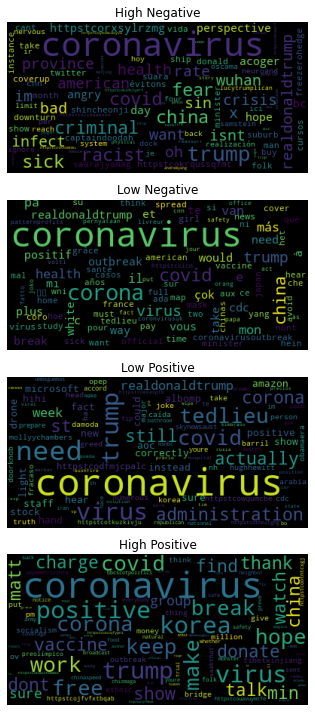

In [40]:
createTermFrequency()

In [26]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart2""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|    2185|
|       HP|     710|
|       HN|     575|
|       LP|     406|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



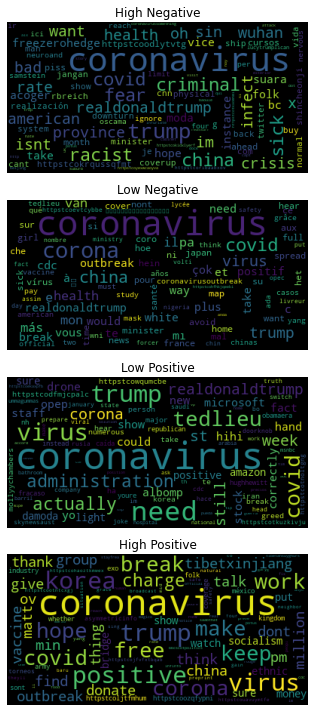

In [39]:
createTermFrequency()

In [25]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart3""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|    1913|
|       HP|     912|
|       HN|     732|
|       LP|     338|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



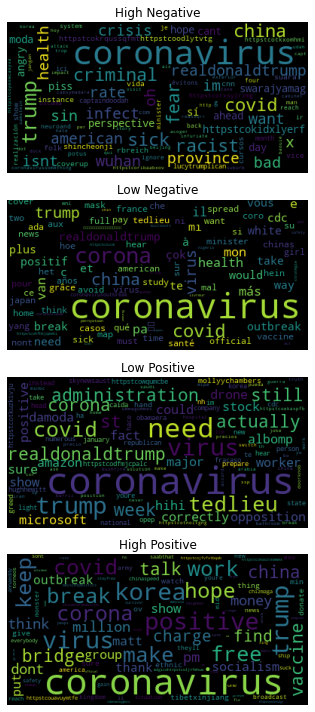

In [41]:
createTermFrequency()

In [24]:
tempDF = spark.sql("""select event_date,coordinates,geo,place,text from marchTweetsPart4""")
cleanDFa = pipeline.fit(tempDF).transform(tempDF) # without stop words
tokenDFa = cleanDFa.withColumn("exploded_text", explode(col("finished_clean_lemma"))).withColumn('sentiment',calc_polarity('text'))
tokenDFa.createOrReplaceTempView("cleanTokens")
spark.sql("""select sentiment, count(*) from cleanTokens group by sentiment""").show(10)

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|       LN|     418|
|       HP|     121|
|       HN|     119|
|       LP|      56|
+---------+--------+



+-----------+-----+
|       text|count|
+-----------+-----+
|coronavirus|   17|
|      trump|    4|
+-----------+-----+
only showing top 2 rows



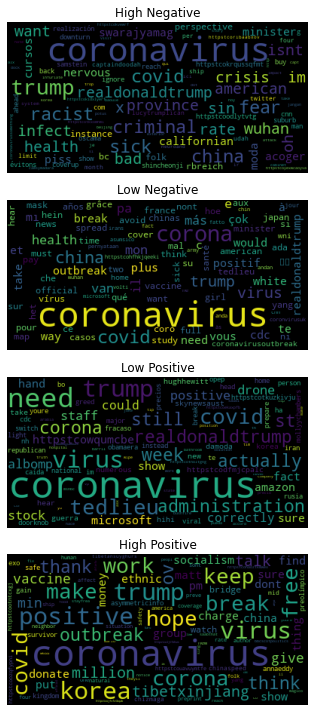

In [42]:
createTermFrequency()

In [38]:
def wordcloudV2(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    wordcloudVar = WordCloud().generate_from_frequencies(corpus_dict)
    return wordcloudVar

def createTermFrequency():
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "HN" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    topTermsDFa.show(2)
    hnwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "LN" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    lnwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "LP" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    lpwc = wordcloudV2(topTermsDFa)
    
    countTermDFa = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens where sentiment like "HP" group by exploded_text""")
    countTermDFa.createOrReplaceTempView("tempTable")
    countTermDFQry = 'select text, count from tempTable where lower(text) not rlike ("get|say|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'
    topTermsDFa = spark.sql(countTermDFQry)
    hpwc = wordcloudV2(topTermsDFa)
        
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))
    ax[0].imshow(hnwc)
    ax[0].set_title('High Negative')
    ax[0].axis('off')
    
    ax[1].imshow(lnwc)
    ax[1].set_title('Low Negative')
    ax[1].axis('off')
    
    ax[2].imshow(lpwc)
    ax[2].set_title('Low Positive')
    ax[2].axis('off')
    
    ax[3].imshow(hpwc)
    ax[3].set_title('High Positive')
    ax[3].axis('off')
    
    plt.tight_layout();
    
    
    #spark.catalog.dropTempView(clusterType)

## Geo Loaction

In [ ]:
df = spark.sql("""select event_date, place.full_name , count(*) as count from marchTweetsPart1 where place.full_name is not null group by event_date, place.full_name order by event_date asc, count desc""")
df.show(2)

In [ ]:
spark.sql("""select * from marchTweetsPart2 where place is not null limit 2""").show()

In [ ]:
#df_part1.printSchema()

In [ ]:
def get_geo_data(place, geo, coordinates):
    print("test")
    geodata = {}
    if coordinates:
      geodata["location"] = str(['coordinates'][0]) + ", " + str(['coordinates'][1])
      geodata["type"] = "coord"
    elif place:
      if place.full_name:
        geodata["location"]=place.full_name
        geodata["type"] = "place"
      elif place.bounding_box:
        place_coords = place.bounding_box.coordinates
        geodata["location"]= str(['place_coords'][0]) + ", " + str(['place_coords'][1])
        geodata["type"] = "coord"
    elif geo:
        geodata["location"]=geo
        geodata["type"] = "location" 
    
    geodata

In [ ]:
geo_loc = udf(get_geo_data)
spark.udf.register("geo_loc", geo_loc)
result = spark.sql("""select * from marchTweetsPart1""").withColumn('geo_loc',geo_loc('place','geo','coordinates'))
result.where(col("place").isNotNull()).show(10)
#spark.sql("""select place.full_name from marchTweetsPart1 where place.full_name is not null""").show(10)